In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat as loadmat
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

# Suppress warnings`
warnings.filterwarnings("ignore")

In [2]:
import xy

# $因子描述：筹码分布（Chip Distribution）$

***计算标的近N日分钟K线的时间等权平均价格，并归一化处理。***
即标的的N日分钟级TWAP价格的价格反映了价格停留时间较长的价格水平，即短期内交易者的筹码成本，当筹码成本越高，对后续价格上涨的限制越大。

1. 数据：标的分钟行情（**对于指数因子，此处采用指数ETF分钟行情**）  
2. 读取N日分钟K线，取N*240个收盘价的均值。
3. 截面上归一化处理。

$参考报告：《》$

## 计算

In [54]:
def cal_CD(mindata):
    cd = mindata.loc['2016-01-28':,:].close.rolling(240*5).apply(lambda x: ((x.mean() - x.min())/(x.max() - x.min())))[::240]
    cd.index = cd.index.map(lambda x: str(x)[:10])
    
    return cd

In [114]:
def cal_VD(mindata):
    vd = (mindata.loc['2016-01-28':]).volume.rolling(240*5).apply(lambda x: (x.mean() - x.min())/(x.max() - x.min()))[::240]
    vd.index = vd.index.map(lambda x: str(x)[:10])
    
    return vd

In [56]:
ETF_ARPP = pd.concat([
    cal_CD(xy.ETFMin50jq).rename('50'),
    cal_CD(xy.ETFMin300jq).rename('300'),
    cal_CD(xy.ETFMin500jq).rename('500'),
    cal_CD(xy.ETFMin1000jq).rename('1000'),
],axis=1).shift(1)

In [115]:
ETF_ARPV = pd.concat([
    cal_VD(xy.ETFMin50jq).rename('50'),
    cal_VD(xy.ETFMin300jq).rename('300'),
    cal_VD(xy.ETFMin500jq).rename('500'),
    cal_VD(xy.ETFMin1000jq).rename('1000'),
],axis=1).shift(1)

In [116]:
ETF_ARPV.dropna()

,50,300,500,1000
2016-11-14,0.071870,0.033057,0.020373,0.026808
2016-11-15,0.092418,0.036217,0.022684,0.039916
2016-11-16,0.112835,0.043390,0.024094,0.037581
2016-11-17,0.125951,0.043601,0.023385,0.028632
2016-11-18,0.133880,0.098259,0.047994,0.028152
...,...,...,...,...
2023-05-17,0.144749,0.088747,0.050415,0.162636
2023-05-18,0.126438,0.083898,0.040643,0.160928
2023-05-19,0.123226,0.159056,0.039024,0.146881
2023-05-22,0.112582,0.133057,0.044453,0.150491


In [117]:
ETF_ARPP.dropna().T[ETF_ARPP.dropna().T > 0.6]

,2016-11-14,2016-11-15,2016-11-16,2016-11-17,2016-11-18,2016-11-21,2016-11-22,2016-11-23,2016-11-24,2016-11-25,...,2023-05-10,2023-05-11,2023-05-12,2023-05-15,2023-05-16,2023-05-17,2023-05-18,2023-05-19,2023-05-22,2023-05-23
50,0.625000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300,NaN,NaN,NaN,0.625820,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500,0.634846,NaN,NaN,0.664425,NaN,0.644859,NaN,NaN,NaN,NaN,...,0.608818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.628877
1000,0.647951,0.64426,0.649459,0.658532,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
ETF_ARPP.dropna().T.loc[['1000']].T.rolling(20).mean().dropna()

,1000
2016-12-09,0.540564
2016-12-12,0.531435
2016-12-13,0.521830
2016-12-14,0.531200
2016-12-15,0.533720
...,...
2023-05-17,0.551952
2023-05-18,0.557007
2023-05-19,0.561462
2023-05-22,0.554874


<Axes: >

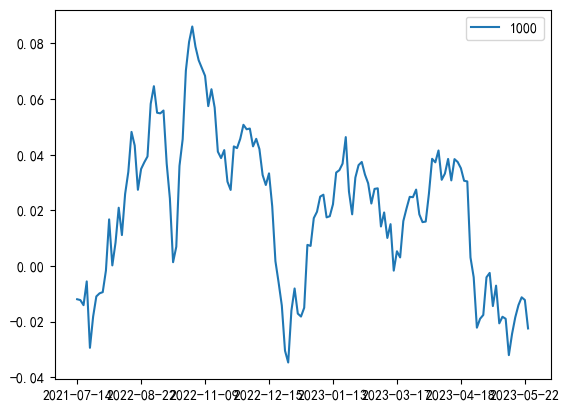

In [113]:
xy.Index_rets.loc[['1000']].T[ETF_ARPV.dropna().T.loc[['1000']].T.rolling(5).mean() > 0.1].dropna().cumsum().plot()

## 评估

### cl-cl

-0.014272182060034517
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

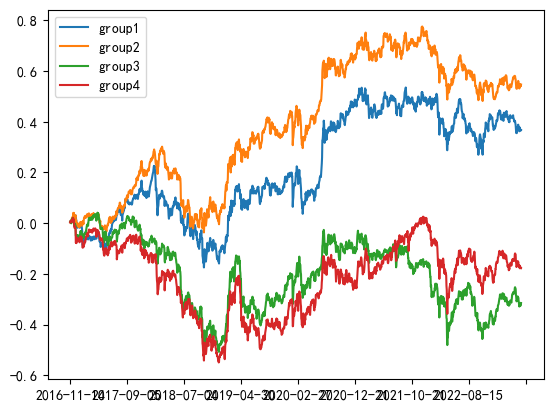

In [57]:
# 分组收益率
gr_cd = xy.cal_rate_group(
    (ETF_ARPV).dropna().rolling(1).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    group_num=4,
    masks=1
)
gr_cd.cumsum().plot()

In [23]:
cd_select

,2016-11-08,2016-11-09,2016-11-10,2016-11-11,2016-11-14,2016-11-15,2016-11-16,2016-11-17,2016-11-18,2016-11-21,...,2023-05-10,2023-05-11,2023-05-12,2023-05-15,2023-05-16,2023-05-17,2023-05-18,2023-05-19,2023-05-22,2023-05-23
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN
500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,-1.0,-1.0,-1.0,-1.0


344.0
yoy: 0.08164849362898481 
 mdd: -0.4149876382058686 
 sharpe: 0.48116962630335264 
 rankIC: -0.01387651177593889 
 rankIR: -0.01976461755381451 
 win%: 0.4849056603773585 
 gain_loss%: -1.1315318921111177


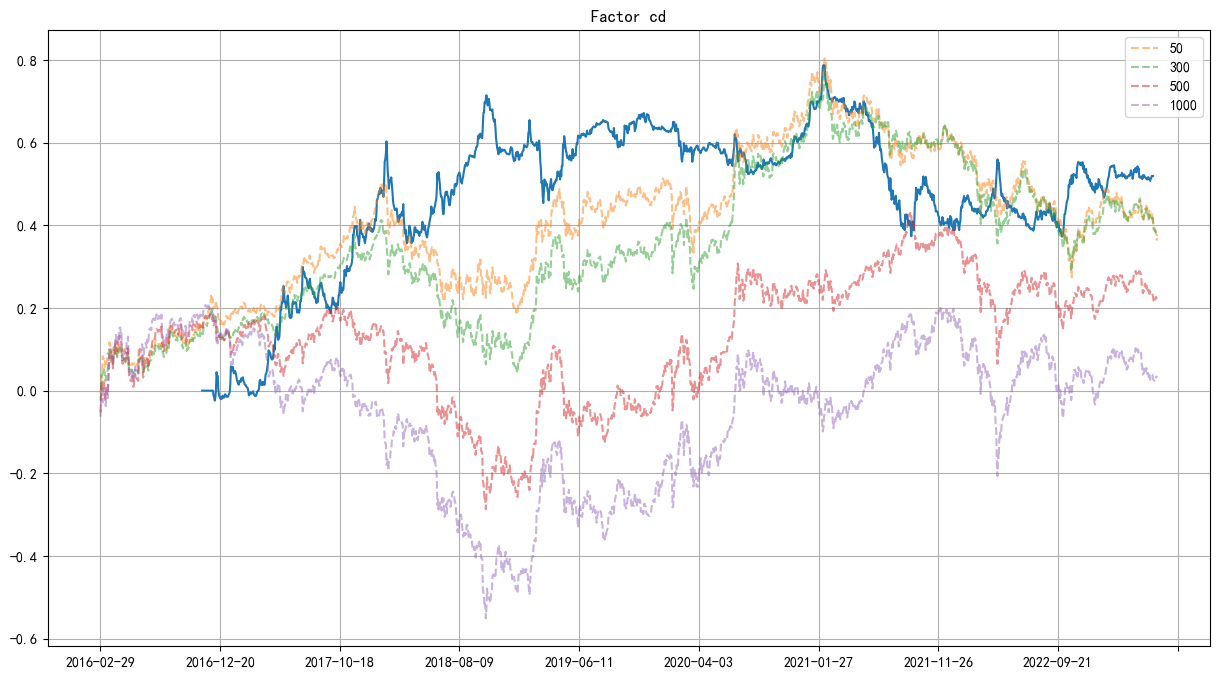

In [50]:
# 单因子强弱
cd_select, cd_rets = xy.single_Factor_backtest(
    (ETF_ARPV/ETF_ARPP).dropna().rolling(20).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    _side=1,
    fee=0.000,
    name='cd'
)

0.01756842775302355

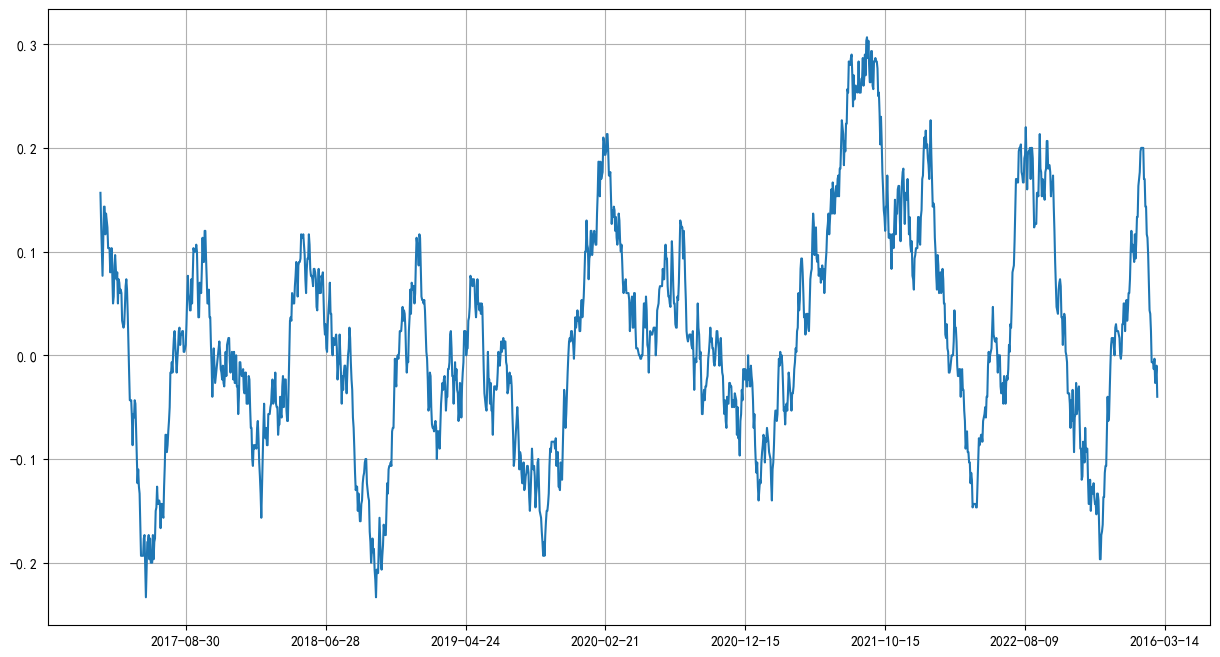

In [24]:
# 因子截面IC趋势
rankIC = xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False).corrwith(ETF_ARPP.dropna().rolling(20).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False))
rankIC.rolling(60).mean().plot(figsize=(15,8),grid=1)
rankIC.mean()

### 择时

In [7]:
fn = 'st_VDIFF.csv'
f = pd.read_csv('E:/PyProject/factors/NewFactor/'+fn,index_col=0).T

In [14]:
f.min()

50      -2.164339
300     -2.086877
500     -2.143168
1000    -1.606227
sz100   -2.226267
kc50    -2.122121
2000    -1.326547
dtype: float64

#### 多头

shrh: 0.0 win%: 0.5469255663430421 gainloss%: -0.8120997395071842 309
shrh: 0.1 win%: 0.5660847880299252 gainloss%: -0.9171500663573122 401
shrh: 0.2 win%: 0.5728346456692913 gainloss%: -0.9750899308132036 508
shrh: 0.3 win%: 0.5807560137457045 gainloss%: -0.9668160654827005 582
shrh: 0.4 win%: 0.5800344234079173 gainloss%: -0.9331236462042544 581
shrh: 0.5 win%: 0.5914179104477612 gainloss%: -0.9874096512682448 536
shrh: 0.6 win%: 0.5950226244343891 gainloss%: -1.0363617425535898 442
shrh: 0.7 win%: 0.5784615384615385 gainloss%: -1.0175486053464873 325
shrh: 0.8 win%: 0.5769230769230769 gainloss%: -0.8975868460620254 182
shrh: 0.9 win%: 0.4864864864864865 gainloss%: -0.9603756243481589 74


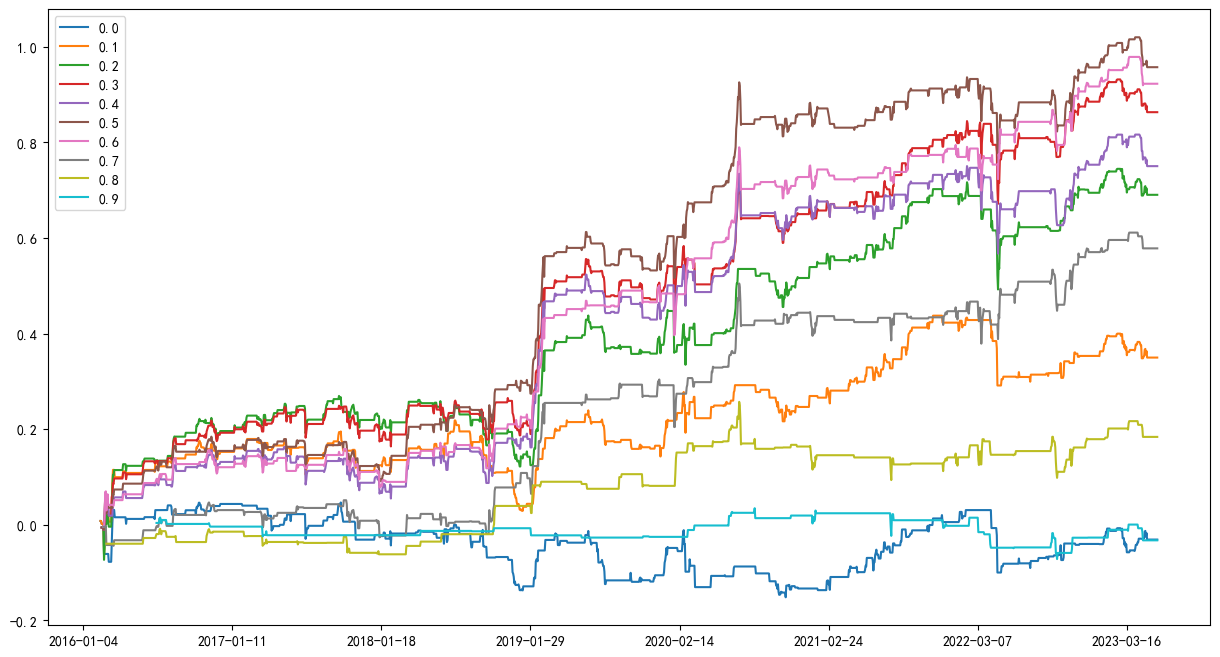

In [59]:
idx_name = '1000'
for i in range(100)[::10]:
    i = 0 + i / 100
    same_dt = set(xy.Index_rets.T[idx_name].index) & set(f[idx_name].dropna().index)
    ts_ret = xy.Index_rets.T[idx_name].loc[f[idx_name][(f[idx_name]>i)&(f[idx_name]<i+0.6)].index&same_dt]
    
    if len(ts_ret) < 1:
        continue
    
    # if i < 0.57:
    #     continue
    
    win_pct = ts_ret[ts_ret>0].shape[0]/ts_ret.shape[0]
    win_loss_ratio = ts_ret[ts_ret>0].mean()/ts_ret[ts_ret<0].mean()
    
    print('shrh:',i, 'win%:', win_pct,'gainloss%:', win_loss_ratio,ts_ret.shape[0] )
    
    pd.Series(ts_ret.cumsum().rename(i),xy.Index_rets.T[idx_name].index).ffill().plot(legend=True,figsize=(15,8))

#### 空头

shrh: 0.0 win%: 0.5747126436781609 gainloss%: -1.9217235499580314 87
shrh: -0.05 win%: 0.5769230769230769 gainloss%: -1.6629358413551658 78
shrh: -0.1 win%: 0.5774647887323944 gainloss%: -1.370693777713108 71
shrh: -0.15 win%: 0.5131578947368421 gainloss%: -1.0745738066124968 76
shrh: -0.2 win%: 0.5116279069767442 gainloss%: -1.021164959817324 86
shrh: -0.25 win%: 0.4444444444444444 gainloss%: -1.205491118226078 108
shrh: -0.3 win%: 0.47058823529411764 gainloss%: -1.223351843173302 136
shrh: -0.35 win%: 0.46060606060606063 gainloss%: -1.4226950185832088 165
shrh: -0.4 win%: 0.44565217391304346 gainloss%: -1.3767863860297187 184
shrh: -0.45 win%: 0.4642857142857143 gainloss%: -1.4437150963545022 224


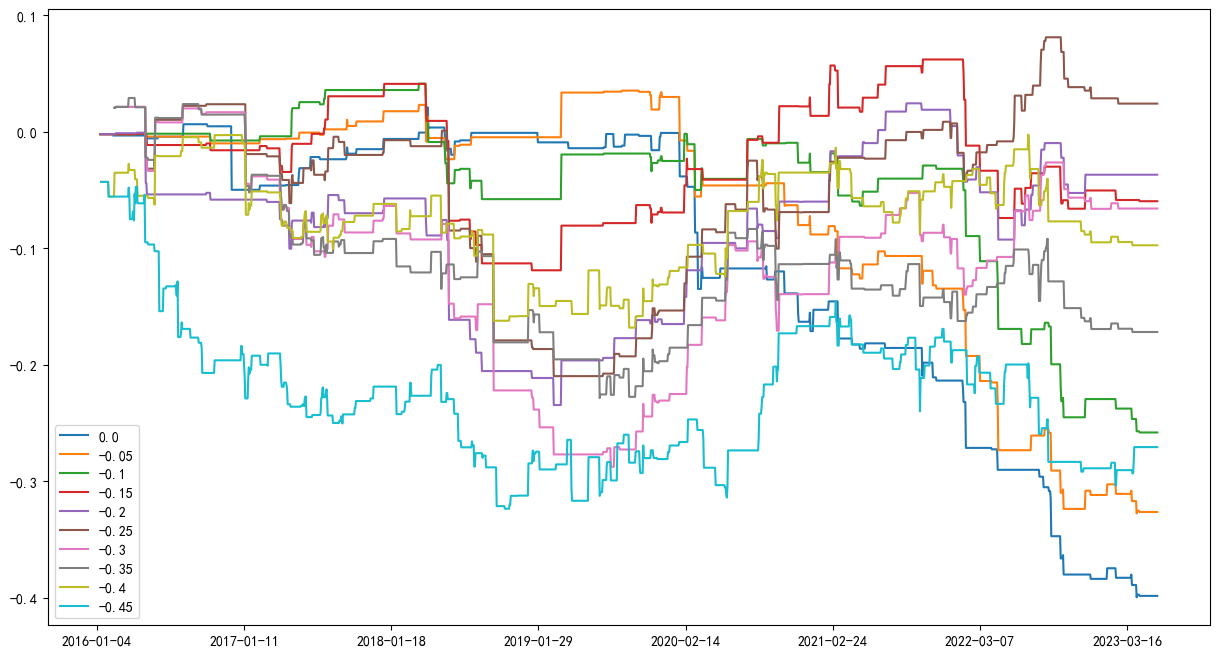

In [64]:
idx_name = '1000'
for i in range(50)[::5]:
    i = 0 - i / 100
    same_dt = set(xy.Index_rets.T[idx_name].index) & set(f[idx_name].dropna().index)
    ts_ret = xy.Index_rets.T[idx_name].loc[f[idx_name][(f[idx_name]<i)&(f[idx_name]>i-0.2)].index&same_dt]
    
    # if len(ts_ret) < 1:
    #     continue
        
    win_pct = ts_ret[ts_ret<0].shape[0]/ts_ret.shape[0]
    win_loss_ratio = ts_ret[ts_ret<0].mean()/ts_ret[ts_ret>0].mean()
    
    print('shrh:',i, 'win%:', win_pct,'gainloss%:', win_loss_ratio,ts_ret.shape[0] )
    
    pd.Series(ts_ret.cumsum().rename(i), xy.Index_rets.T[idx_name].index).ffill().plot(legend=True,figsize=(15,8))

In [51]:
i

0.5

### cl_op

-0.17104207413953082
1 0.9880503144654088
2 0.9880503144654088
3 0.9880503144654088
4 0.9880503144654088


<Axes: >

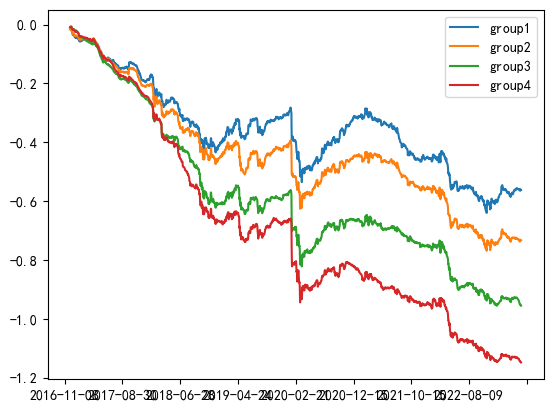

In [93]:
# 分组收益率
gr_cd = xy.cal_rate_group(
    ETF_ARPP.dropna().rolling(20).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    group_num=4,
    masks=1
)
gr_cd.cumsum().plot()

In [89]:
xy.bonus_open_cl_rets.loc[['50', '300','500', '1000'],'2016-02-28':'2022-07-09']

,2016-02-29,2016-03-01,2016-03-02,2016-03-03,2016-03-04,2016-03-07,2016-03-08,2016-03-09,2016-03-10,2016-03-11,...,2022-06-27,2022-06-28,2022-06-29,2022-06-30,2022-07-01,2022-07-04,2022-07-05,2022-07-06,2022-07-07,2022-07-08
50,-0.001902,-0.000025,0.003684,-0.000016,-0.003973,0.000133,-0.002574,-0.019803,-0.010444,-0.008829,...,0.005496,-0.000075,-0.003239,0.000011,0.002677,-0.004666,0.002803,-0.002919,-0.000789,0.007920
300,-0.002867,0.001344,0.001101,-0.000309,-0.003559,0.004884,-0.001511,-0.019870,-0.005110,-0.007611,...,0.004520,-0.000241,-0.003376,0.000327,0.001005,-0.004355,0.002129,-0.002923,0.000596,0.006219
500,-0.005387,0.002123,-0.001626,0.000732,-0.003784,0.011585,-0.000202,-0.023799,0.000067,-0.011120,...,0.005086,0.000877,-0.002588,0.001893,-0.000508,0.001040,0.001957,-0.003150,-0.000139,0.004329
1000,-0.006869,-0.000062,-0.002804,-0.000044,-0.005466,0.010141,-0.001915,-0.023954,0.000438,-0.012422,...,0.005296,-0.000155,-0.002468,0.001477,0.000645,-0.001314,0.000851,-0.002929,0.000326,0.003767


82.0
yoy: -0.1130051336056056 
 mdd: -0.7323222080331878 
 sharpe: -2.278692077515507 
 rankIC: -0.13734610123119015 
 rankIR: -0.1816870520935196 
 win%: 0.37169811320754714 
 gain_loss%: -0.9312030767063352


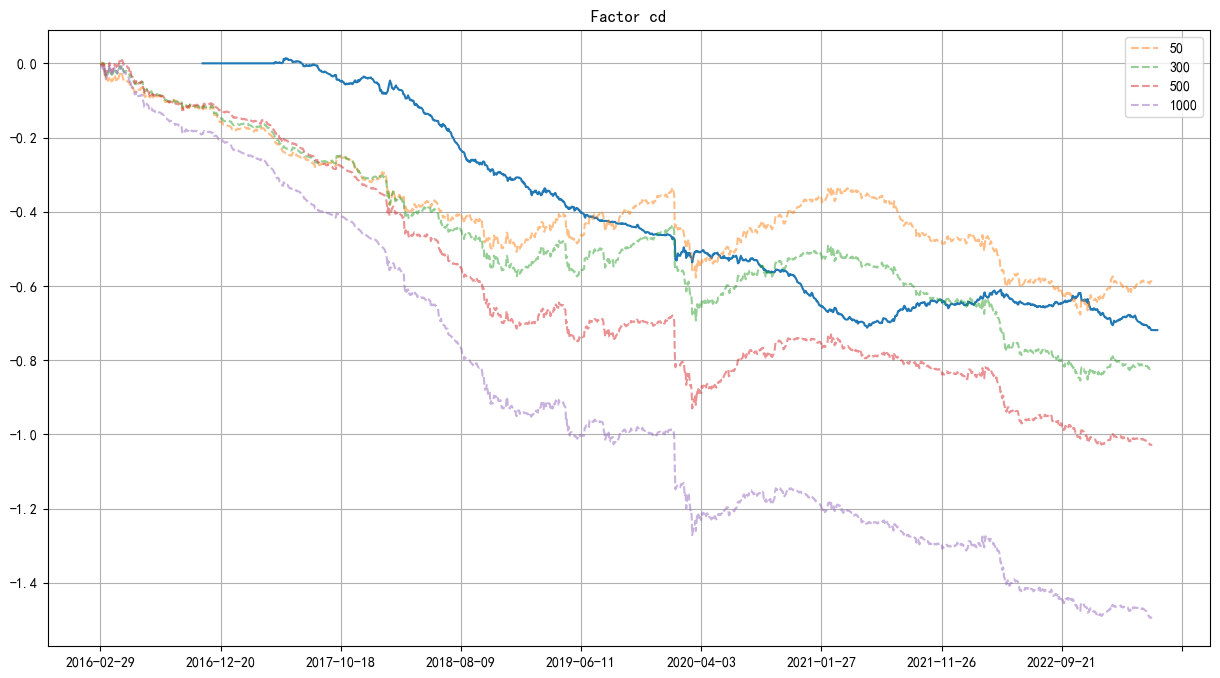

In [95]:
# 单因子强弱
cd_select, cd_rets = xy.single_Factor_backtest(
    ETF_ARPP.dropna().rolling(120).mean().T.loc[['50', '300','500', '1000'],'2016-02-28':],
    xy.bonus_open_cl_rets.loc[['50', '300','500', '1000'],'2016-02-28':],
    _side=1,
    fee=0.000,
    name='cd'
)

-0.13734610123119015

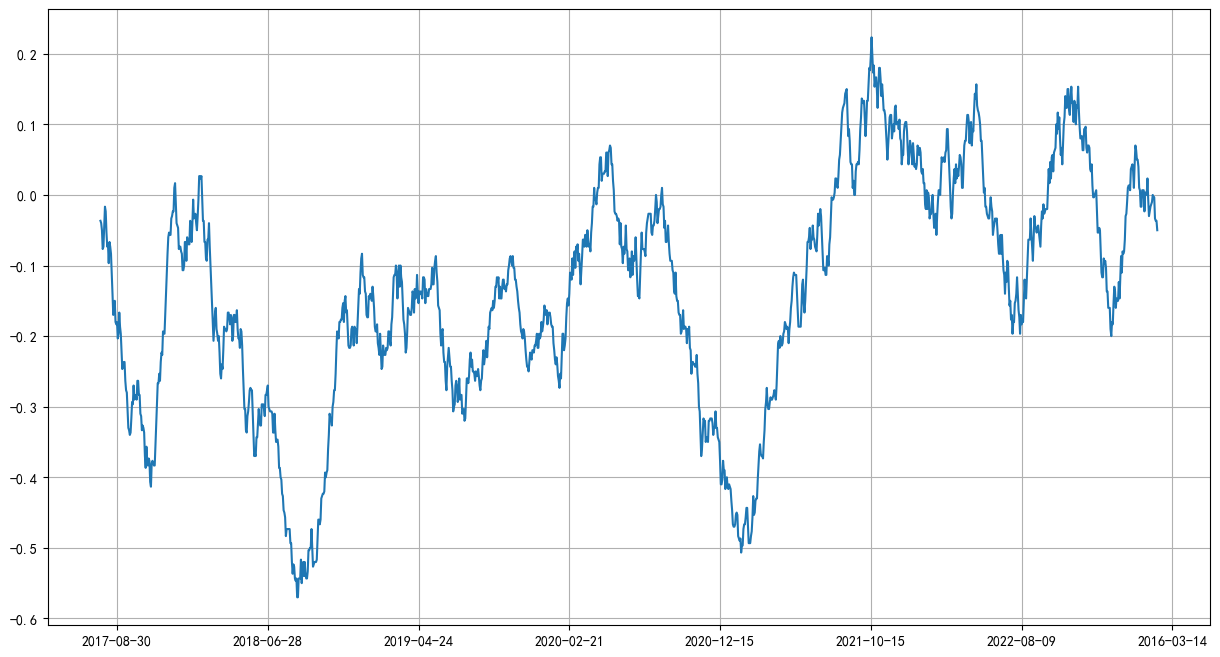

In [96]:
# 因子截面IC趋势
rankIC = xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False).corrwith(ETF_ARPP.dropna().rolling(120).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False))
rankIC.rolling(60).mean().plot(figsize=(15,8),grid=1)
rankIC.mean()

In [ ]:
ETFKURScountjq_s.T.to_csv('../NewFactor/Kur_idxETF.csv')

In [48]:
liquidity = pd.read_csv(r'E:\PyProject\factors\DailyFactor\momentum.csv',index_col=0)
liquidity.index = liquidity.index.map(lambda x: str(x)[:-4] + 'SZ' if str(x)[-1]=='E' else str(x)[:-4] + 'SH')

In [49]:
liquidity

,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,...,2023-06-16,2023-06-19,2023-06-20,2023-06-21,2023-06-26,2023-06-27,2023-06-28,2023-06-29,2023-06-30,2023-07-03
code,,,,,,,,,,,,,,,,,,,,,
000001.SZ,-0.390526,-0.415990,-0.385876,-0.360584,-0.381318,-0.310052,-0.310201,-0.315103,-0.351017,-0.358840,...,-0.655623,-0.726205,-0.728236,-0.752572,-0.698724,-0.675630,-0.625298,-0.710284,-0.754465,-0.829362
000002.SZ,0.920627,0.930322,0.655123,0.659927,1.050503,0.873930,0.892898,0.863617,0.979511,0.843437,...,-0.922372,-0.960819,-0.916530,-0.936182,-0.900347,-0.817768,-0.815260,-0.916168,-0.828390,-0.850367
000004.SZ,0.970853,1.075434,1.114526,1.182912,1.456613,1.396787,1.202416,1.073937,1.246707,1.184907,...,-0.459367,-0.430395,-0.325853,-0.123250,-0.038284,0.156446,0.334607,0.568782,0.751898,0.596525
000005.SZ,1.232142,1.273647,1.119811,1.023970,1.254087,0.974353,0.827647,0.809447,0.834218,0.797233,...,-1.116219,-1.193111,-1.391775,-1.510342,-1.517147,-1.604493,-1.745663,-2.058601,-2.273529,-2.474811
000006.SZ,0.316599,0.383880,0.326528,0.213789,0.225940,0.188954,0.140273,0.160925,0.169424,0.125730,...,-0.219353,-0.287539,-0.252308,-0.224455,-0.192642,-0.121472,-0.121557,-0.210589,-0.192430,-0.190513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688799.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.304814,0.326354,0.450698,0.501934,0.497410,0.418613,0.432501,0.391464,0.330685,0.356770
688800.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.673622,-1.701436,-1.572247,-1.535542,-1.289437,-1.133664,-1.218855,-1.343145,-1.306723,-1.330906
688819.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.321725,-0.284156,-0.283668,-0.240472,-0.151137,-0.137554,-0.139407,-0.235910,-0.217506,-0.196054


In [50]:
Index_liquidity = xy.read_Factor(xy.trd_dates,name='beta',df=liquidity)

<Axes: >

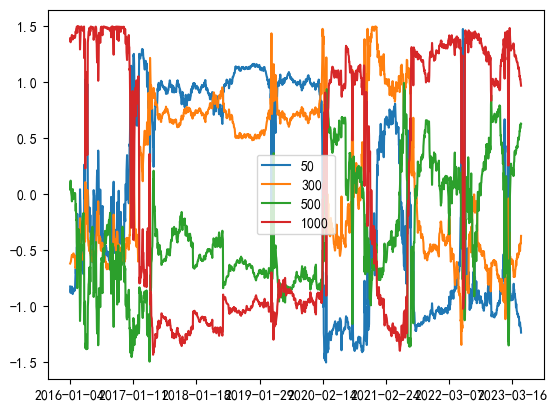

In [52]:
Index_liquidity.T.plot()

0.02223363335380625
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

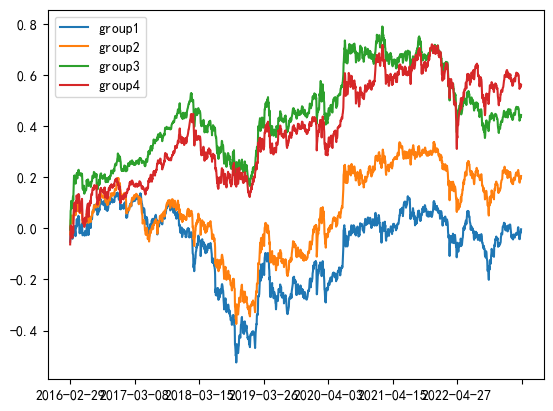

In [53]:
# 分组收益率
xy.cal_rate_group(
    (Index_liquidity).T.dropna().rolling(1).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    group_num=4,
    masks=1
).cumsum().plot()

-0.01760363688523689
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

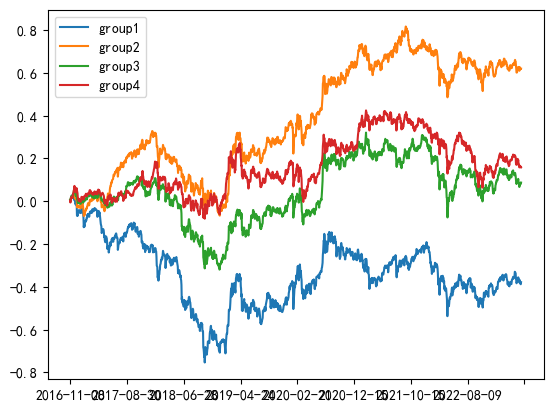

In [48]:
# 分组收益率
gr_cd = xy.cal_rate_group(
    (ETF_ARPV).dropna().rolling(1).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    group_num=4,
    masks=1
)
gr_cd.cumsum().plot()